In [1]:
"""
author: Vetivert? 💐 
created: 16/04/2025 @ 16:07:49
"""

import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pandas as pd # type: ignore
import seaborn as sns # type: ignore

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV # type: ignore
from sklearn.preprocessing import StandardScaler, label_binarize # type: ignore
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix,\
     make_scorer # type: ignore
from sklearn.ensemble import RandomForestClassifier # type: ignore
from scipy.stats import randint, uniform

import xgboost as xgb
from xgboost import XGBClassifier

import sys
import os

current_dir = os.path.abspath('')

parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from src.utils.prefix_path import *
from src.utils.functions import *


In [2]:
# Load dataset
df = pd.read_csv(FULL_DATA_PATH, sep=";", header=3) #separator is ;
# df = df.apply(pd.to_numeric, errors='coerce')

# Drop redundant cols + rows
df.drop(REDUNDANT_ROWS, inplace=True)
df.index = range(len(df)) #reset index
df.drop(REDUNDANT_COLS, axis=1, inplace=True)

df.fillna(FILLNA_VALUES) #df[1] = df[1].fillna(0)
df['Other'] = pd.to_numeric(df['Other'], errors='coerce').fillna(1) #addtional diseases
df.iloc[np.where(df == '8(nặng xin về)')] = 8

for i in HEART_INDEX:
    df[i] = pd.to_numeric(df[i], errors='coerce')
    print(f"{i}: {df[str(i)].mean()}")
print("\nDiastolic BP < 80: Huyết áp tối ưu \nSystolic BP <= 130: Huyết áp bình thường, 130<x<140: Tiền tăng huyết áp")

# df.drop(HEART_INDEX, axis=1, inplace=True)

uniques, counts = np.unique(df['Diagnosis'], return_counts=True)
print('\nDiagnosis\'s classes: ',dict(zip(uniques, np.round(counts * 100 / len(df['Diagnosis']), 2))))
df['Diagnosis'] = np.where(df['Diagnosis'] == '3', '2', df['Diagnosis'])
df['Day of illness'] = np.where(df['Day of illness'] == '55', '5', df['Day of illness'])
df['Systolic BP'] = np.where(df['Systolic BP'] == 1120, 120, df['Systolic BP'])


# hematoma group
hema = df[HEMATOMA_COLS]
hema = hema.assign(stacked=hema.astype(str).agg(''.join, axis=1))
hema
hema['stacked'] = (pd.to_numeric(hema['stacked'], errors='coerce'))
hema['stacked_int'] = np.where(hema['stacked'] == 0, 0, 1)

df.insert(df.columns.get_loc(HEMATOMA_COLS[0]), 'hematoma', hema['stacked_int']) #get col index by its name
df.drop(HEMATOMA_COLS, axis=1, inplace=True)

# bleeding group
bleed = df[BLEEDING_COLS]
bleed = bleed.assign(stacked=bleed.astype(str).agg(''.join, axis=1))
bleed['stacked'] = (pd.to_numeric(bleed['stacked'], errors='coerce'))
bleed['stacked_int'] = np.where(bleed['stacked'] == 0, 0, 1)

df.insert(df.columns.get_loc(BLEEDING_COLS[0]), 'Mucosa membrane bleeding', bleed['stacked_int'])
df.drop(BLEEDING_COLS, axis=1, inplace=True)

# additional diseases group
add_diseases = df[ADDITIONAL_DISEASES]
add_diseases = add_diseases.assign(stacked=add_diseases.astype(str).agg(''.join, axis=1))
add_diseases['stacked'] = (pd.to_numeric(add_diseases['stacked'], errors='coerce'))
add_diseases['stacked_int'] = np.where(add_diseases['stacked'] == 0, 0, 1)

df.insert(df.columns.get_loc(ADDITIONAL_DISEASES[0]), 'additional_diseases', add_diseases['stacked_int'])
df.drop(ADDITIONAL_DISEASES, axis=1, inplace=True)


Pulse rate: 89.60148514851485
Systolic BP: 117.25
Diastolic BP: 70.63861386138613

Diastolic BP < 80: Huyết áp tối ưu 
Systolic BP <= 130: Huyết áp bình thường, 130<x<140: Tiền tăng huyết áp

Diagnosis's classes:  {'1': 56.4, '2': 39.66, '3': 3.94}


In [3]:
# strategy 1, 20% test_set = 0.2 * range(line 0, line 221) + 0.2 * range(line 222, line 407)
df_set = df.loc[222:, :'Oliguria'].copy().fillna(0)

df_alt_ast = df.loc[222:, 'Glu1':'GGT9'].copy()
# print(df_alt_ast['AST1'])
alt_df = pd.DataFrame()
ast_df = pd.DataFrame()
for i in range(9):
    col_1 = 'ALT' + str(i+1)
    alt_df[col_1] = df_alt_ast[col_1]

    col_2 = 'AST' + str(i+1)
    ast_df[col_2] = df_alt_ast[col_2]
# print(ast_df)

alt_df = alt_df.apply(lambda x: pd.Series(x.dropna().values), axis=1)
ast_df = ast_df.apply(lambda x: pd.Series(x.dropna().values), axis=1)
# print(alt_df)
alt_df[0] = alt_df[0].str.replace(',', '.').astype(float)
alt_df[0].fillna(alt_df[0].mean(), inplace=True)

ast_df[0] = ast_df[0].str.replace(',', '.').astype(float)
ast_df[0].fillna(ast_df[0].mean(), inplace=True)

df_plt = df.loc[222:, 'WBC1':'MPV 9'].copy()
df_plt = df_plt.apply(lambda x: pd.Series(x.dropna().values), axis=1)
for i in range(8):
    df_plt[i] = df_plt[i].str.replace(',', '.')
    df_plt[i] = pd.to_numeric(df_plt[i], errors='coerce')
    df_plt[i].fillna(df_plt[i].mean(), inplace=True)

# df_plt[6] = df_plt[6].str.replace('`', '').replace(',', '.')
# df_plt[6] = pd.to_numeric(df_plt[6], errors='coerce')
# df_plt[7] = df_plt[7].str.replace(',', '.')
# df_plt[7] = pd.to_numeric(df_plt[7], errors='coerce')
# print(df_plt.iloc[:,0:4])
# print(df_plt.isnull().sum())
# print(df_plt[7])

# df_set['AST1'] = ast_df[0].astype(float)   # -> -0.02 ACC
# df_set['ALT1'] = alt_df[0].astype(float) # -> -0.05 ACC
# df_set['WBC1'] = df_plt[0].astype(float) 
# df_set['N1'] = df_plt[1].astype(float) 
# df_set['L1'] = df_plt[2].astype(float) 
# df_set['RBC1'] = df_plt[3].astype(float)
# df_set['Hb1'] = df_plt[4].astype(float)
# df_set['HCT1'] = df_plt[5].astype(float)
# df_set['PLT1'] = df_plt[6].astype(float) # -> +0.03 ACC
# df_set['MPV1'] = df_plt[7].astype(float) # -> +0.02 ACC 

x1_train, x1_test, y1_train, y1_test = train_test_split(df_set.drop(columns=['Diagnosis']), df_set['Diagnosis'], \
                                                    test_size=0.2, random_state=17, stratify=df_set['Diagnosis'])
x1_features = x1_train.columns

# x1_train, x1_test, y1_train, y1_test = x1_train.to_numpy(), x1_test.to_numpy(), y1_train.to_numpy(), y1_test.to_numpy()

print('x1_train shape: ', x1_train.shape, 'y1_train shape: ',  y1_train.shape)
print('x1_test shape: ', x1_test.shape, 'y1_test shape: ',  y1_test.shape)
uniques, counts = np.unique(y1_test, return_counts=True)
print('percentage of classes: ',dict(zip(uniques, np.round(counts * 100 / len(y1_test), 2))))

# rf_1 = RandomForestClassifier(n_estimators=100, random_state=17)
# rf_1.fit(x1_train, y1_train)

# y1_pred = rf_1.predict(x1_test)
# accuracy = accuracy_score(y1_test, y1_pred)
# print(f"Accuracy: {accuracy:.2f}")

# # Classification report
# print("\nClassification Report:")
# print(classification_report(y1_test, y1_pred))

# uniques, counts = np.unique(y1_pred, return_counts=True)
# print('percentage of predictions: ',dict(zip(uniques, np.round(counts * 100 / len(y1_pred), 2))))

# # Plotting feature importances
# importances = rf_1.feature_importances_
# indices = np.argsort(importances)[::-1]

# plt.figure(figsize=(12, 8))
# plt.title("Feature importances")
# plt.bar(range(x1_train.shape[1]), importances[indices], align="center")
# plt.xticks(range(x1_train.shape[1]), features[indices], rotation=90)
# plt.xlim([-1, x1_train.shape[1]])
# plt.axhline(y=importances.mean(), color='r', linestyle='--')
# plt.show()

x1_train shape:  (147, 24) y1_train shape:  (147,)
x1_test shape:  (37, 24) y1_test shape:  (37,)
percentage of classes:  {'1': 45.95, '2': 54.05}


In [ ]:

# Define parameter distributions
param_distributions = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 25),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['sqrt', 'log2', None]
}
scorer = make_scorer(roc_auc_score)

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=17),
    param_distributions=param_distributions,
    n_iter=100,  # number of parameter settings sampled
    cv=10,
    scoring=scorer,
    n_jobs=-1,
    verbose=2,
    random_state=17
)

# Fit the random search
random_search.fit(x1_train, y1_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=15, n_estimators=328; total time=   0.7s
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=15, n_estimators=328; total time=   0.7s
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=15, n_estimators=328; total time=   0.7s
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=15, n_estimators=328; total time=   0.8s
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=15, n_estimators=328; total time=   0.8s
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=15, n_estimators=328; total time=   0.8s
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=15, n_estimators=328; total time=   0.8s
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=17),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f863de8d660>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f863de8e380>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f863de8e560>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f863de8ea70>},
                   random_state=17,
                   scoring=make_scorer(roc_auc_score, response_method='predict'),
                   verbose=2)

Accuracy: 0.65

Classification Report:
              precision    recall  f1-score   support

           1       0.58      0.82      0.68        17
           2       0.77      0.50      0.61        20

    accuracy                           0.65        37
   macro avg       0.68      0.66      0.64        37
weighted avg       0.68      0.65      0.64        37

percentage of predictions:  {'1': 64.86, '2': 35.14}


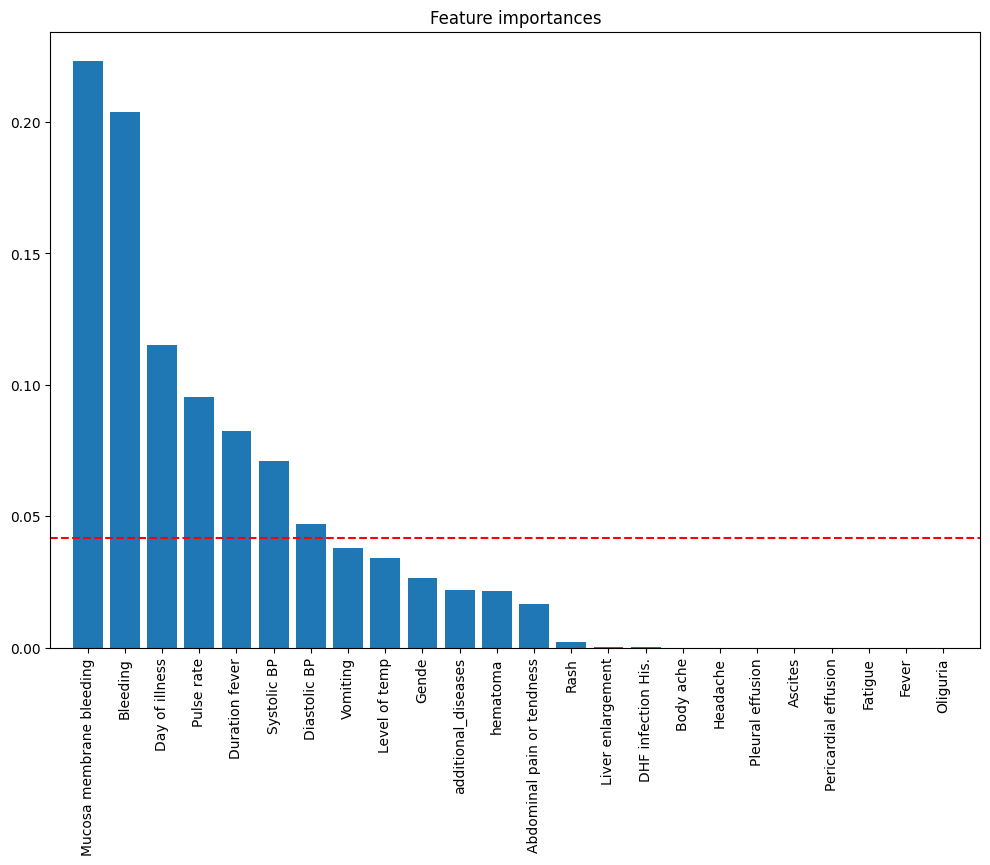

In [4]:
# rf_1 = RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=3,
#                        n_estimators=347, random_state=17) # acc: 70, 1_f1: 73, 2_f1: 67
# rf_1 = RandomForestClassifier(max_depth=19, min_samples_leaf=8, min_samples_split=23,
#                        n_estimators=491, random_state=17) # RBC+WBC, acc: 73, 1_f1: 74, 2_f1: 72
# rf_1 = RandomForestClassifier(max_depth=34, max_features='log2', min_samples_leaf=8,
#                        min_samples_split=10, n_estimators=71, random_state=17) # PLT+MPV, acc: 73, 1_f1: 74, 2_f1: 72
rf_1 = RandomForestClassifier(max_depth=38, max_features='log2', min_samples_leaf=5,
                       min_samples_split=3, n_estimators=374, random_state=17) # ALT+AST, acc: 68, 1_f1: 68, 2_f1: 67
rf_1.fit(x1_train, y1_train)

y1_pred = rf_1.predict(x1_test)
accuracy = accuracy_score(y1_test, y1_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y1_test, y1_pred))

uniques, counts = np.unique(y1_pred, return_counts=True)
print('percentage of predictions: ',dict(zip(uniques, np.round(counts * 100 / len(y1_pred), 2))))

# Plotting feature importances
importances = rf_1.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature importances")
plt.bar(range(x1_train.shape[1]), importances[indices], align="center")
plt.xticks(range(x1_train.shape[1]), x1_features[indices], rotation=90)
plt.xlim([-1, x1_train.shape[1]])
plt.axhline(y=importances.mean(), color='r', linestyle='--')
plt.show()

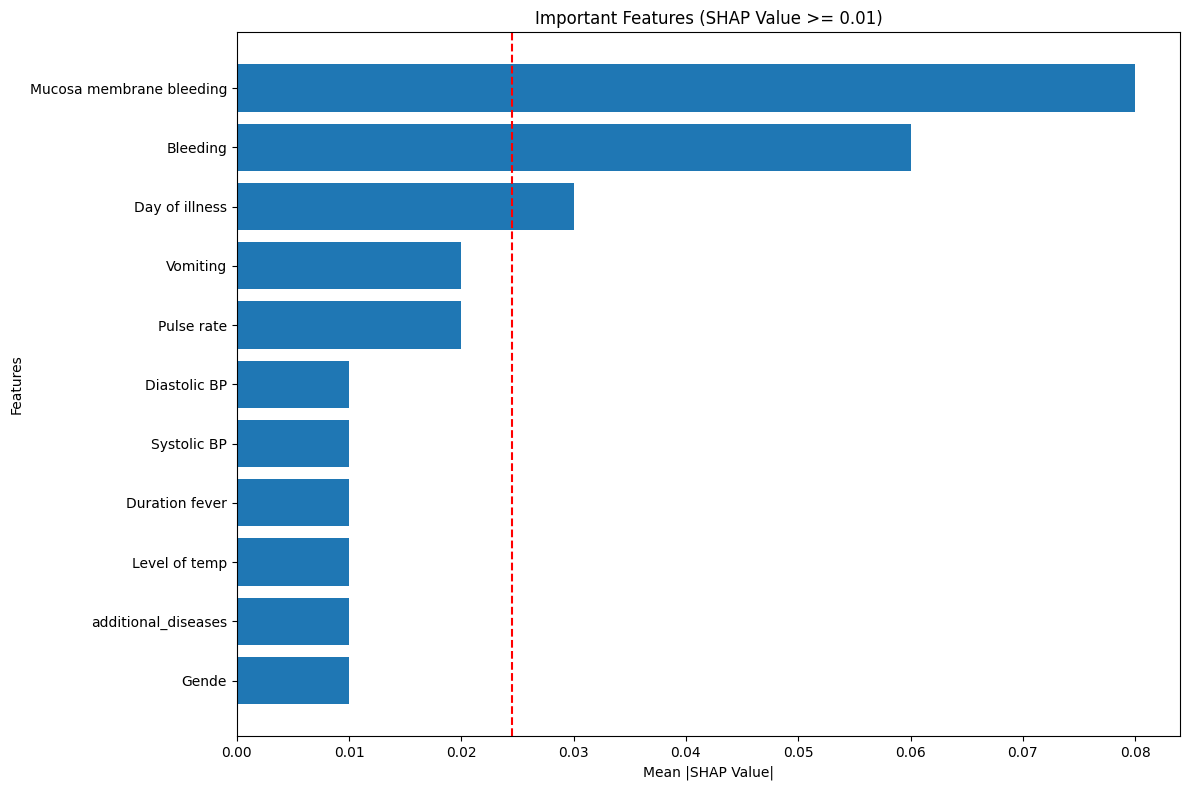

In [8]:
import shap

explainer = shap.TreeExplainer(rf_1)

shap_values = explainer(x1_test)

m = np.abs(shap_values.values).mean(0).round(2)
# for i in range(m.shape[0]):
#     if m[i][0] >= 0.01:
#         print(f"{features[i]}: {m[i][0]}")

# shap.summary_plot(shap_values, x2_test)
# Create a bar plot of feature importance
plt.figure(figsize=(12, 8))
important_features = []
important_values = []

for i in range(m.shape[0]):
    if m[i][0] >= 0.01:
        important_features.append(x1_features[i])
        important_values.append(m[i][0])

# Sort by importance
sorted_indices = np.argsort(important_values)
sorted_features = [important_features[i] for i in sorted_indices]
sorted_values = [important_values[i] for i in sorted_indices]

plt.barh(range(len(sorted_features)), sorted_values, align='center')
plt.axvline(x=np.mean(sorted_values), color='r', linestyle='--')
plt.yticks(range(len(sorted_features)), sorted_features)
plt.xlabel('Mean |SHAP Value|')
plt.ylabel('Features')
plt.title('Important Features (SHAP Value >= 0.01)')
plt.tight_layout()
plt.show()

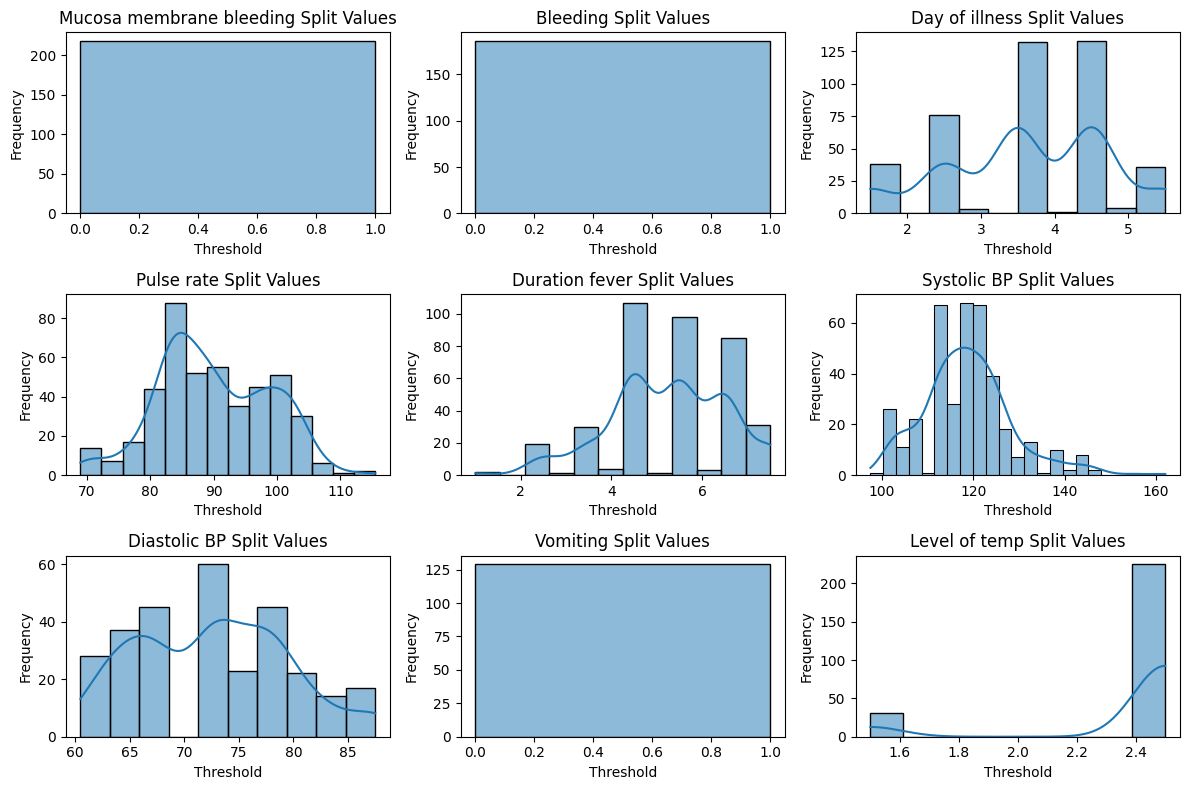

In [7]:
# Get split values for each feature
split_values = extract_split_values(rf_1, x1_features)


# Sort features by importance
importances = rf_1.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
top_features = [x1_features[i] for i in sorted_idx[:9]]  # Top 5 features

plt.figure(figsize=(12, 8))
for i, feature in enumerate(top_features):
    plt.subplot(3, 3, i+1)
    # plt.hist(split_values[feature], bins=20)
    sns.histplot(split_values[feature], kde=True)
    plt.title(f"{feature} Split Values")
    plt.xlabel("Threshold")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

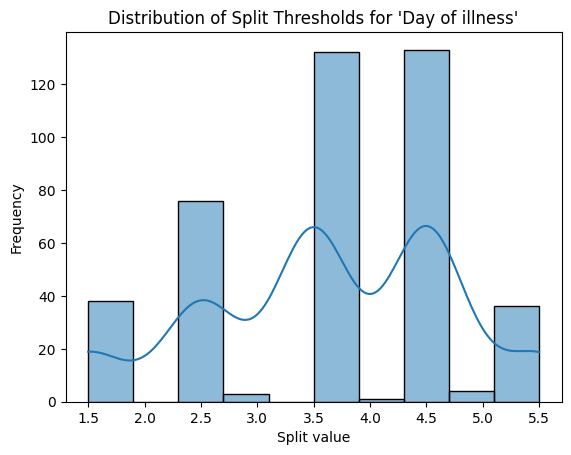

Mean split value: 3.637115839243499
Median split value: 3.5
Most common split value: 4.5


In [19]:
# Get access to individual trees
trees = rf_1.estimators_

split_values = []

for tree in trees:
    tree_ = tree.tree_
    feature = tree_.feature
    threshold = tree_.threshold
    for i in range(tree_.node_count):
        if feature[i] == x1_train.columns.get_loc('Day of illness'):
            split_values.append(threshold[i])

sns.histplot(split_values, kde=True)
# plt.hist(split_values, bins=20, color='skyblue')
plt.title("Distribution of Split Thresholds for 'Day of illness'")
plt.xlabel("Split value")
plt.ylabel("Frequency")
plt.show()

print("Mean split value:", np.mean(split_values))
print("Median split value:", np.median(split_values))
print("Most common split value:", max(set(split_values), key=split_values.count))

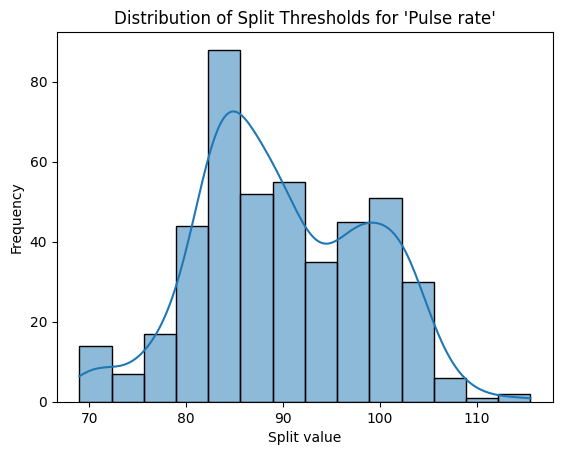

Mean split value: 90.01118568232663
Median split value: 89.0
Most common split value: 84.5


In [20]:
# Get access to individual trees
trees = rf_1.estimators_

split_values = []

for tree in trees:
    tree_ = tree.tree_
    feature = tree_.feature
    threshold = tree_.threshold
    for i in range(tree_.node_count):
        if feature[i] == x1_train.columns.get_loc('Pulse rate'):
            split_values.append(threshold[i])

sns.histplot(split_values, kde=True)
# plt.hist(split_values, bins=20, color='skyblue')
plt.title("Distribution of Split Thresholds for 'Pulse rate'")
plt.xlabel("Split value")
plt.ylabel("Frequency")
plt.show()

print("Mean split value:", np.mean(split_values))
print("Median split value:", np.median(split_values))
print("Most common split value:", max(set(split_values), key=split_values.count))

In [8]:
alt_ast = df.loc[222:, 'Glu1':'GGT9'].copy().fillna(0)
alt_ast = alt_ast.drop(['Bil TP7', 'Bil TT 7'], axis=1)

plt_df = df.loc[222:, 'WBC1':'MPV 9'].copy().fillna(0)
# print(alt_ast.shape)

alt_ast = alt_ast.apply(pd.to_numeric, errors='coerce')
plt_df = plt_df.apply(pd.to_numeric, errors='coerce')

# for i in range(plt.shape[0]):
#     plt[i] = plt[i].str.replace(',', '.')
#     plt[i] = pd.to_numeric(plt[i], errors='coerce')
    
XA_train, XA_test, YA_train, YA_test = train_test_split(alt_ast, df_set['Diagnosis'], \
                                                    test_size=0.2, random_state=17, stratify=df_set['Diagnosis'])
alt_ast_features = XA_train.columns

XP_train, XP_test, YP_train, YP_test = train_test_split(plt_df, df_set['Diagnosis'], \
                                                    test_size=0.2, random_state=17, stratify=df_set['Diagnosis'])
plt_features = XP_train.columns

# param_distributions = {
#     'n_estimators': randint(50, 500),
#     'max_depth': randint(5, 50),
#     'min_samples_split': randint(2, 25),
#     'min_samples_leaf': randint(1, 20),
#     'max_features': ['sqrt', 'log2', None]
# }
# scorer = make_scorer(roc_auc_score)

# # Setup RandomizedSearchCV
# random_search = RandomizedSearchCV(
#     estimator=RandomForestClassifier(random_state=17),
#     param_distributions=param_distributions,
#     n_iter=100,  # number of parameter settings sampled
#     cv=10,
#     scoring=scorer,
#     n_jobs=-1,
#     verbose=2,
#     random_state=17
# )

# # Fit the random search
# # random_search.fit(XA_train, YA_train)
# random_search.fit(XP_train, YP_train)

Accuracy: 0.65

Classification Report:
              precision    recall  f1-score   support

           1       0.60      0.71      0.65        17
           2       0.71      0.60      0.65        20

    accuracy                           0.65        37
   macro avg       0.65      0.65      0.65        37
weighted avg       0.66      0.65      0.65        37

percentage of predictions:  {'1': 54.05, '2': 45.95}


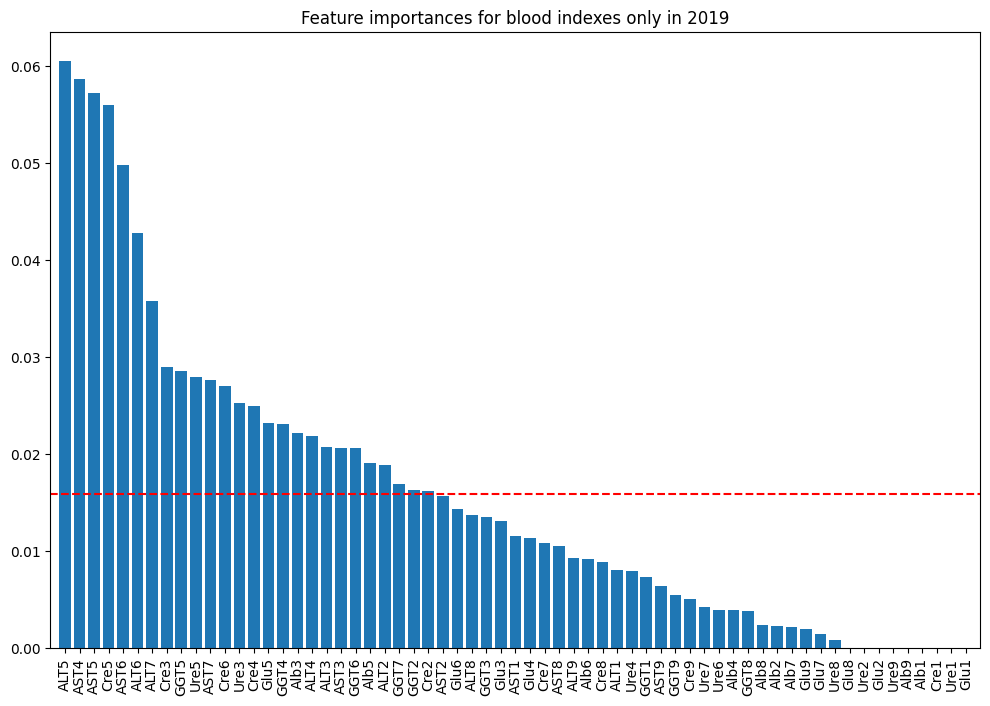

In [9]:
rf_altast = RandomForestClassifier(max_depth=25, max_features='log2', min_samples_leaf=4,
                       min_samples_split=3, n_estimators=348, random_state=17)
rf_altast.fit(XA_train, YA_train)

YA_pred = rf_altast.predict(XA_test)
accuracy = accuracy_score(YA_test, YA_pred)
print(f"Accuracy: {accuracy:.2f}")
features = XA_train.columns

# Classification report
print("\nClassification Report:")
print(classification_report(YA_test, YA_pred))

uniques, counts = np.unique(YA_pred, return_counts=True)
print('percentage of predictions: ',dict(zip(uniques, np.round(counts * 100 / len(YA_pred), 2))))

# Plotting feature importances
importances = rf_altast.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature importances for blood indexes only in 2019")
plt.bar(range(XA_train.shape[1]), importances[indices], align="center")
plt.xticks(range(XA_train.shape[1]), features[indices], rotation=90)
plt.xlim([-1, XA_train.shape[1]])
plt.axhline(y=importances.mean(), color='r', linestyle='--')
plt.show()

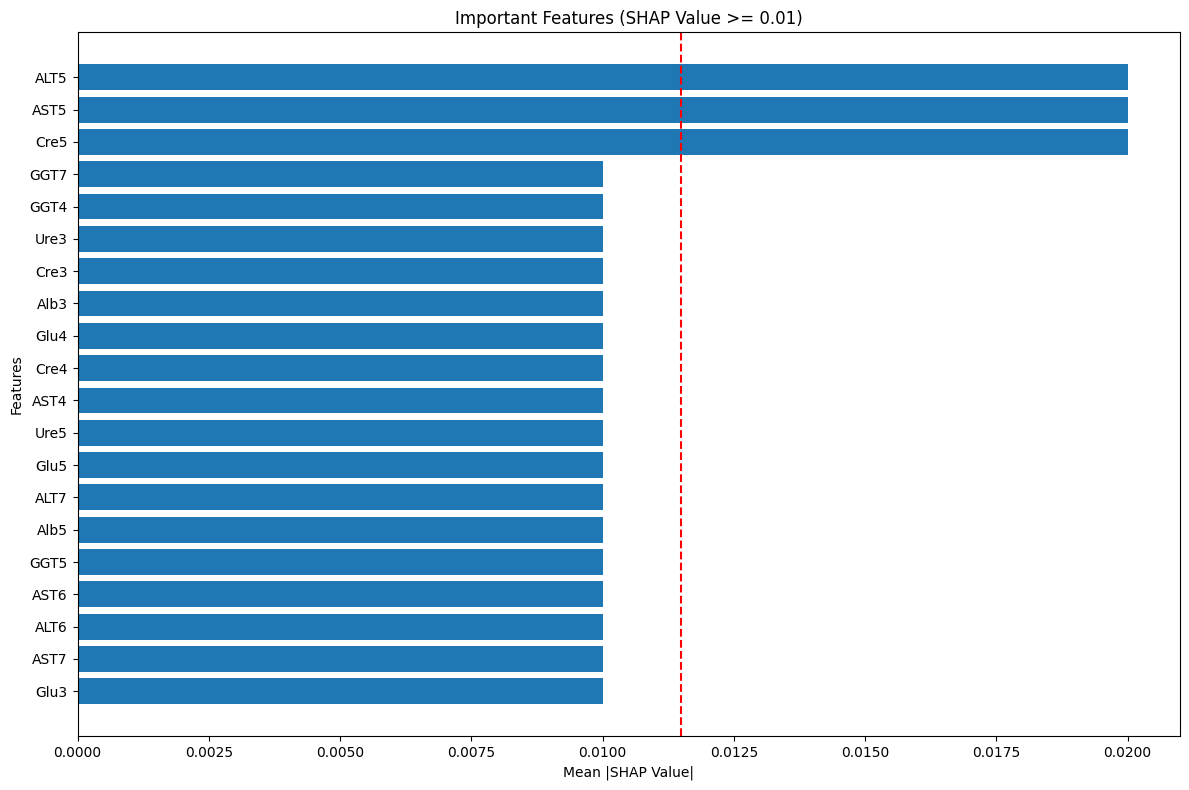

In [11]:
import shap

explainer = shap.TreeExplainer(rf_altast)

shap_values = explainer(XA_test)

m = np.abs(shap_values.values).mean(0).round(2)
# for i in range(m.shape[0]):
#     if m[i][0] >= 0.01:
#         print(f"{features[i]}: {m[i][0]}")

# shap.summary_plot(shap_values, x2_test)
# Create a bar plot of feature importance
plt.figure(figsize=(12, 8))
important_features = []
important_values = []

for i in range(m.shape[0]):
    if m[i][0] >= 0.01:
        important_features.append(alt_ast_features[i])
        important_values.append(m[i][0])

# Sort by importance
sorted_indices = np.argsort(important_values)
sorted_features = [important_features[i] for i in sorted_indices]
sorted_values = [important_values[i] for i in sorted_indices]

plt.barh(range(len(sorted_features)), sorted_values, align='center')
plt.axvline(x=np.mean(sorted_values), color='r', linestyle='--')
plt.yticks(range(len(sorted_features)), sorted_features)
plt.xlabel('Mean |SHAP Value|')
plt.ylabel('Features')
plt.title('Important Features (SHAP Value >= 0.01)')
plt.tight_layout()
plt.show()

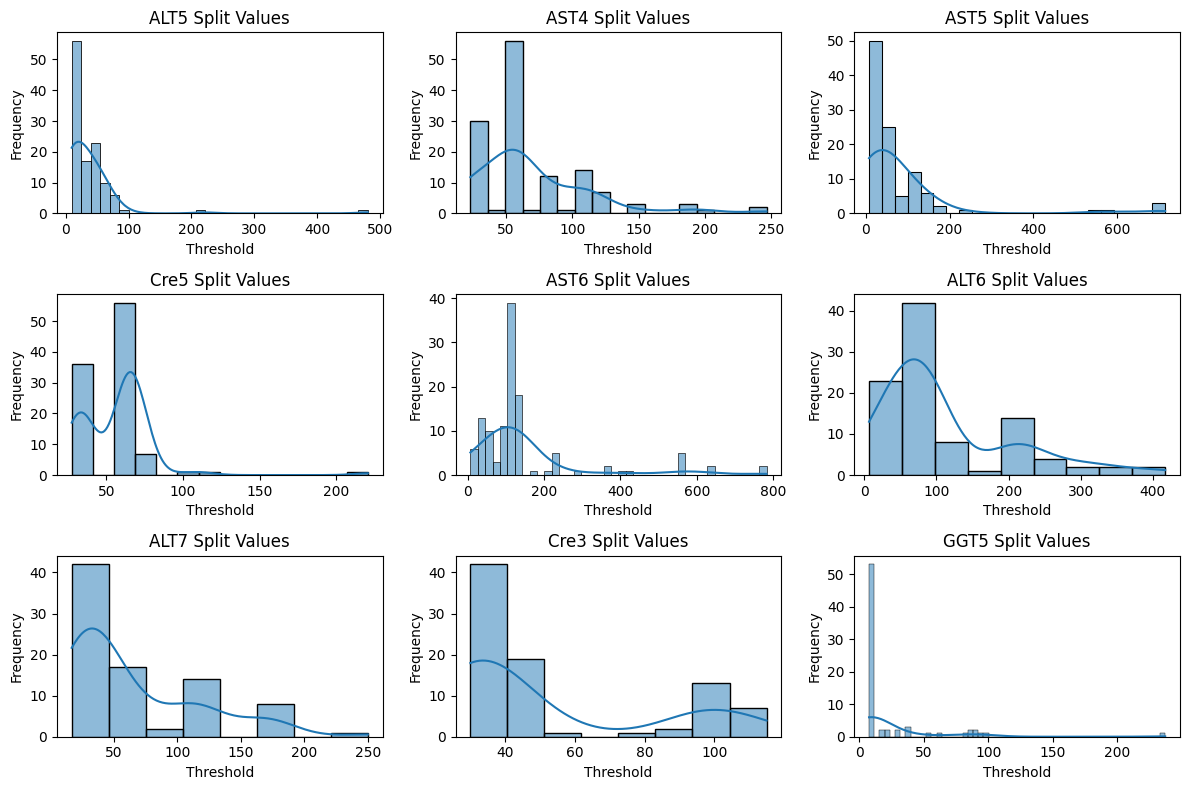

In [13]:
# Get split values for each feature
split_values = extract_split_values(rf_altast, alt_ast_features)


# Sort features by importance
importances = rf_altast.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
top_features = [alt_ast_features[i] for i in sorted_idx[:9]]  # Top 5 features

plt.figure(figsize=(12, 8))
for i, feature in enumerate(top_features):
    plt.subplot(3, 3, i+1)
    # plt.hist(split_values[feature], bins=20)
    sns.histplot(split_values[feature], kde=True)
    plt.title(f"{feature} Split Values")
    plt.xlabel("Threshold")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

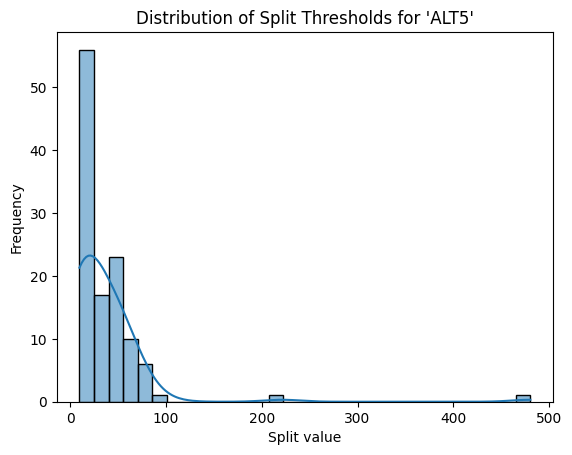

Mean split value: inf
Median split value: 26.0
Most common split value: 9.5


In [14]:
# Get access to individual trees
trees = rf_altast.estimators_

split_values = []

for tree in trees:
    tree_ = tree.tree_
    feature = tree_.feature
    threshold = tree_.threshold
    for i in range(tree_.node_count):
        if feature[i] == XA_train.columns.get_loc('ALT5'):
            split_values.append(threshold[i])

sns.histplot(split_values, kde=True)
# plt.hist(split_values, bins=20, color='skyblue')
plt.title("Distribution of Split Thresholds for 'ALT5'")
plt.xlabel("Split value")
plt.ylabel("Frequency")
plt.show()

print("Mean split value:", np.mean(split_values))
print("Median split value:", np.median(split_values))
print("Most common split value:", max(set(split_values), key=split_values.count))

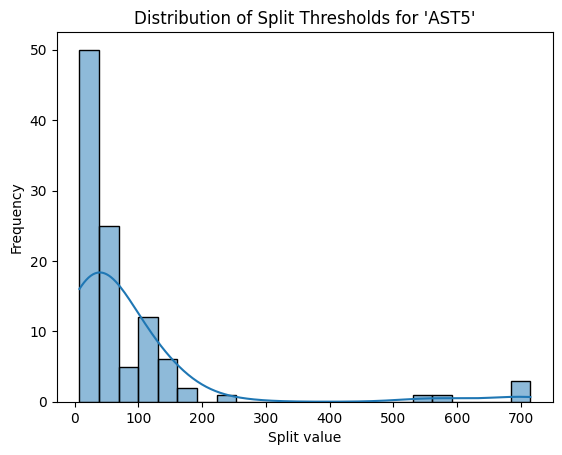

Mean split value: inf
Median split value: 47.0
Most common split value: 23.5


In [15]:
# Get access to individual trees
trees = rf_altast.estimators_

split_values = []

for tree in trees:
    tree_ = tree.tree_
    feature = tree_.feature
    threshold = tree_.threshold
    for i in range(tree_.node_count):
        if feature[i] == XA_train.columns.get_loc('AST5'):
            split_values.append(threshold[i])

sns.histplot(split_values, kde=True)
# plt.hist(split_values, bins=20, color='skyblue')
plt.title("Distribution of Split Thresholds for 'AST5'")
plt.xlabel("Split value")
plt.ylabel("Frequency")
plt.show()

print("Mean split value:", np.mean(split_values))
print("Median split value:", np.median(split_values))
print("Most common split value:", max(set(split_values), key=split_values.count))

Accuracy: 0.70

Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.71      0.69        17
           2       0.74      0.70      0.72        20

    accuracy                           0.70        37
   macro avg       0.70      0.70      0.70        37
weighted avg       0.70      0.70      0.70        37

percentage of predictions:  {'1': 48.65, '2': 51.35}


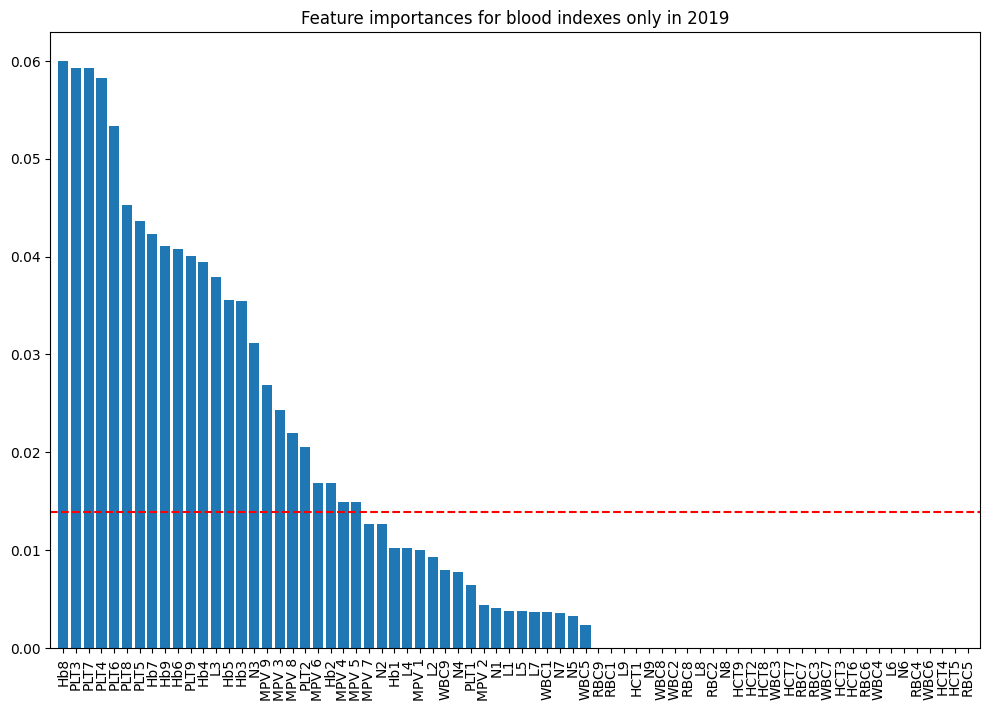

In [16]:
rf_PLT = RandomForestClassifier(max_depth=44, max_features='log2', min_samples_leaf=3,
                       min_samples_split=16, n_estimators=455, random_state=17)
rf_PLT.fit(XP_train, YP_train)

YP_pred = rf_PLT.predict(XP_test)
accuracy = accuracy_score(YP_test, YP_pred)
print(f"Accuracy: {accuracy:.2f}")
features = XP_train.columns

# Classification report
print("\nClassification Report:")
print(classification_report(YP_test, YP_pred))


uniques, counts = np.unique(YP_pred, return_counts=True)
print('percentage of predictions: ',dict(zip(uniques, np.round(counts * 100 / len(YP_pred), 2))))

# Plotting feature importances
importances = rf_PLT.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title(f"Feature importances for blood indexes only in 2019")
plt.bar(range(XP_train.shape[1]), importances[indices], align="center")
plt.xticks(range(XP_train.shape[1]), features[indices], rotation=90)
plt.xlim([-1, XP_train.shape[1]])
plt.axhline(y=importances.mean(), color='r', linestyle='--')
plt.show()

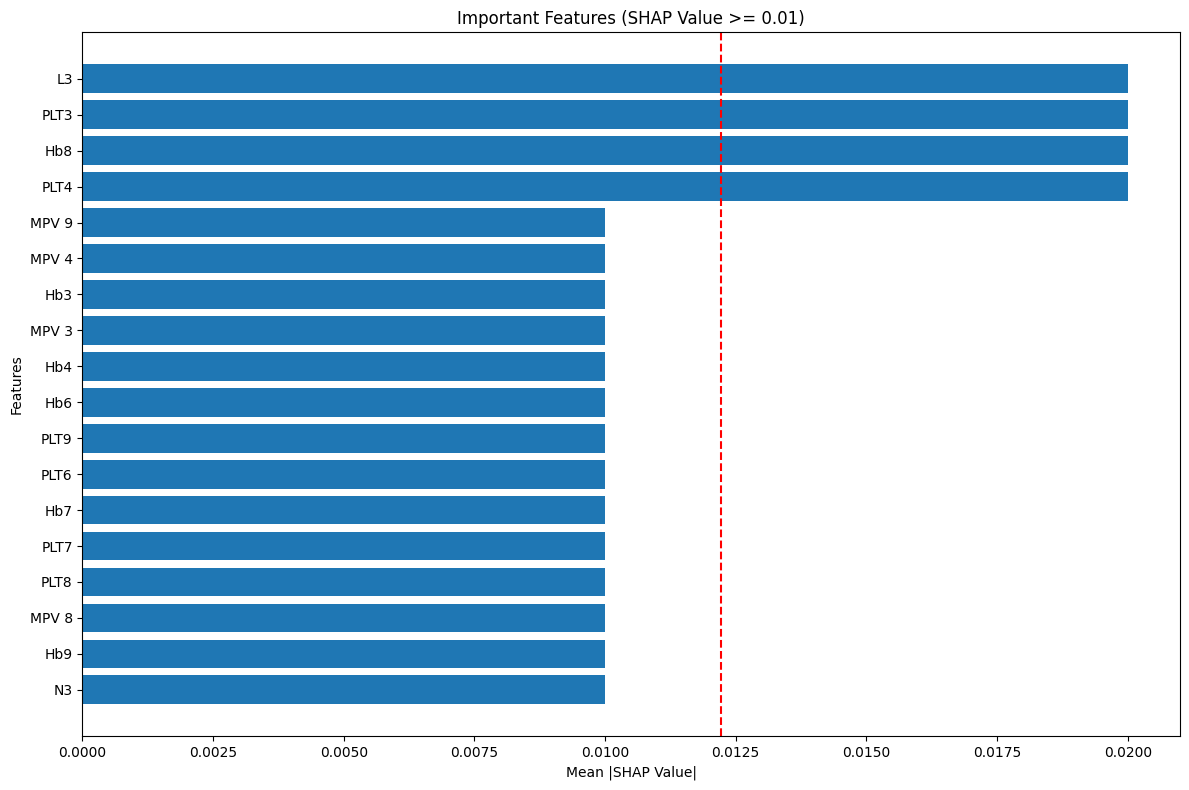

In [15]:
import shap

explainer = shap.TreeExplainer(rf_PLT)

shap_values = explainer(XP_test)

m = np.abs(shap_values.values).mean(0).round(2)
# for i in range(m.shape[0]):
#     if m[i][0] >= 0.01:
#         print(f"{features[i]}: {m[i][0]}")

# shap.summary_plot(shap_values, x2_test)
# Create a bar plot of feature importance
plt.figure(figsize=(12, 8))
important_features = []
important_values = []

for i in range(m.shape[0]):
    if m[i][0] >= 0.01:
        important_features.append(plt_features[i])
        important_values.append(m[i][0])

# Sort by importance
sorted_indices = np.argsort(important_values)
sorted_features = [important_features[i] for i in sorted_indices]
sorted_values = [important_values[i] for i in sorted_indices]

plt.barh(range(len(sorted_features)), sorted_values, align='center')
plt.axvline(x=np.mean(sorted_values), color='r', linestyle='--')
plt.yticks(range(len(sorted_features)), sorted_features)
plt.xlabel('Mean |SHAP Value|')
plt.ylabel('Features')
plt.title('Important Features (SHAP Value >= 0.01)')
plt.tight_layout()
plt.show()

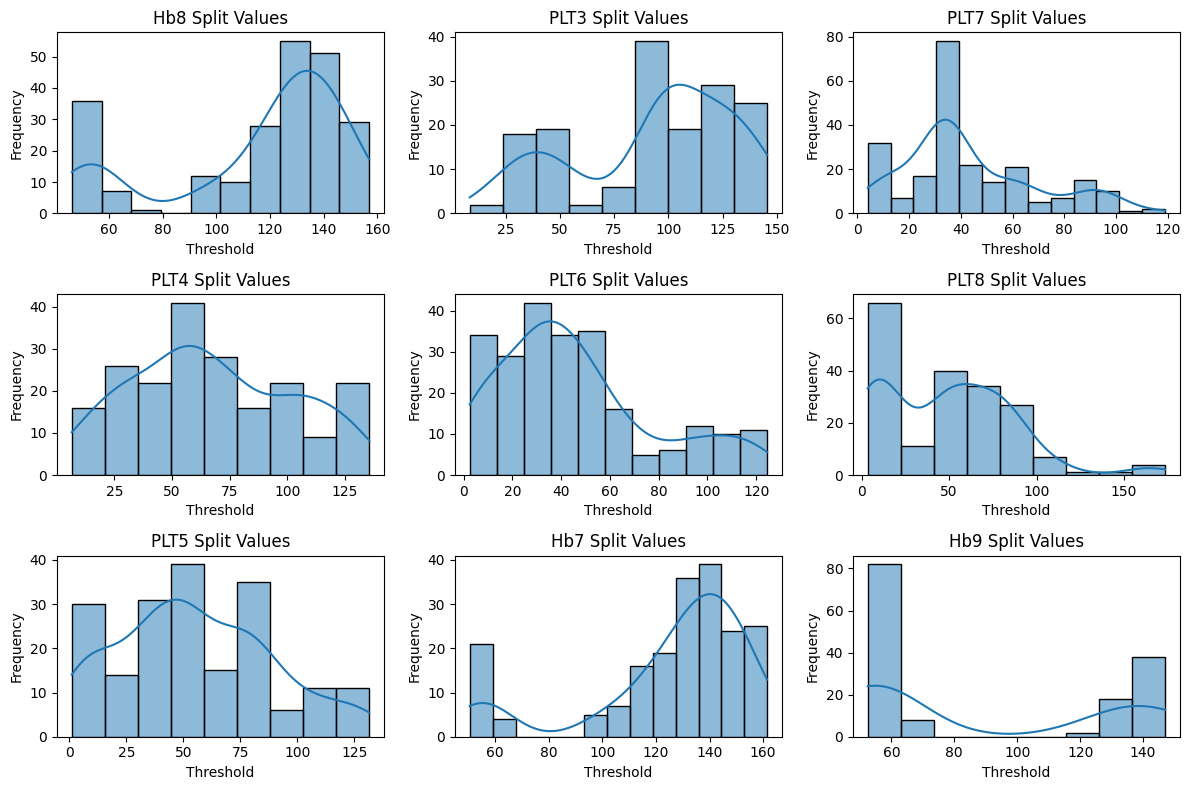

In [16]:
# Get split values for each feature
split_values = extract_split_values(rf_PLT, plt_features)


# Sort features by importance
importances = rf_PLT.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
top_features = [plt_features[i] for i in sorted_idx[:9]]  # Top 5 features

plt.figure(figsize=(12, 8))
for i, feature in enumerate(top_features):
    plt.subplot(3, 3, i+1)
    # plt.hist(split_values[feature], bins=20)
    sns.histplot(split_values[feature], kde=True)
    plt.title(f"{feature} Split Values")
    plt.xlabel("Threshold")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

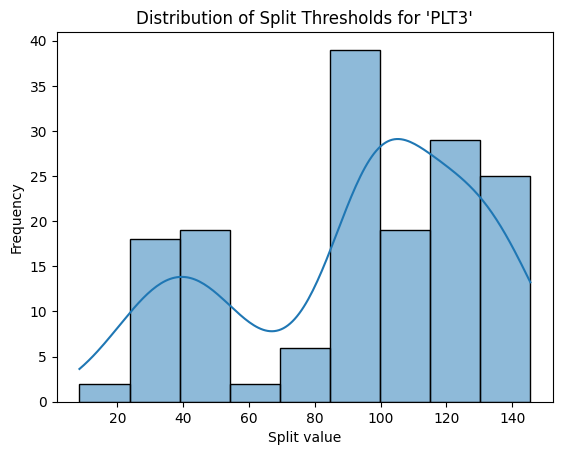

Mean split value: 93.33018867924528
Median split value: 99.5
Most common split value: 124.0


In [17]:
# Get access to individual trees
trees = rf_PLT.estimators_

split_values = []

for tree in trees:
    tree_ = tree.tree_
    feature = tree_.feature
    threshold = tree_.threshold
    for i in range(tree_.node_count):
        if feature[i] == XP_train.columns.get_loc('PLT3'):
            split_values.append(threshold[i])

sns.histplot(split_values, kde=True)
# plt.hist(split_values, bins=20, color='skyblue')
plt.title("Distribution of Split Thresholds for 'PLT3'")
plt.xlabel("Split value")
plt.ylabel("Frequency")
plt.show()

print("Mean split value:", np.mean(split_values))
print("Median split value:", np.median(split_values))
print("Most common split value:", max(set(split_values), key=split_values.count))

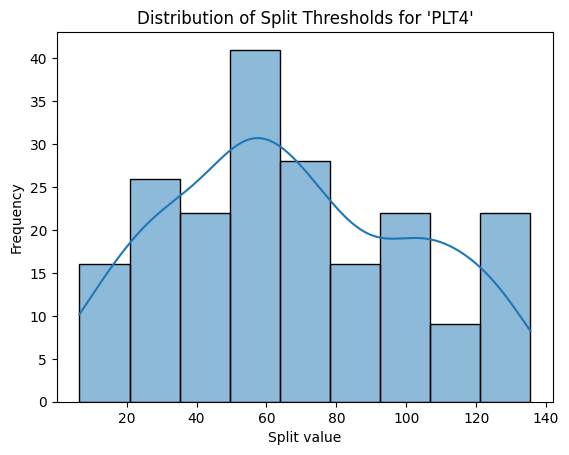

Mean split value: 67.03465346534654
Median split value: 59.75
Most common split value: 54.5


In [18]:
# Get access to individual trees
trees = rf_PLT.estimators_

split_values = []

for tree in trees:
    tree_ = tree.tree_
    feature = tree_.feature
    threshold = tree_.threshold
    for i in range(tree_.node_count):
        if feature[i] == XP_train.columns.get_loc('PLT4'):
            split_values.append(threshold[i])

sns.histplot(split_values, kde=True)
# plt.hist(split_values, bins=20, color='skyblue')
plt.title("Distribution of Split Thresholds for 'PLT4'")
plt.xlabel("Split value")
plt.ylabel("Frequency")
plt.show()

print("Mean split value:", np.mean(split_values))
print("Median split value:", np.median(split_values))
print("Most common split value:", max(set(split_values), key=split_values.count))

## XGBOOST

In [21]:
xgb_1 = XGBClassifier(n_estimators=100,
                      learning_rate=0.1,
                      max_depth=5,
                      use_label_encoder=False,
                      eval_metric='logloss')
x1_train = x1_train.to_numpy()
y1_train = y1_train.to_numpy()
x1_test = x1_test.to_numpy()
y1_test = y1_test.to_numpy()

for i in range(len(y1_train)):
    if y1_train[i] == '1':
        y1_train[i] = 0
    elif y1_train[i] == '2':
        y1_train[i] = 1  

for i in range(len(y1_test)):
    if y1_test[i] == '1':
        y1_test[i] = 0
    elif y1_test[i] == '2':
        y1_test[i] = 1  
               
xgb_1.fit(x1_train, y1_train)

y1_pred_proba = xgb_1.predict(x1_test)
y1_pred = [1 if p >= 0.5 else 0 for p in y1_pred_proba]
y1_test = [1 if p >= 0.5 else 0 for p in y1_test]
# print(y1_pred)
# print(y1_test)
# Accuracy
accuracy = accuracy_score(y1_test, y1_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y1_test, y1_pred))

# Confusion matrix
cm = confusion_matrix(y1_test, y1_pred)
print("\nConfusion Matrix:")
print(cm)

# ROC AUC
roc_auc = roc_auc_score(y1_test, y1_pred_proba)
print(f"\nROC AUC: {roc_auc:.4f}")


# xgb.plot_importance(xgb_1, importance_type='gain', max_num_features=10)
# plt.title('Top 10 Feature Importances (by Gain)')
# plt.show()

Accuracy: 0.7027

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.82      0.72        17
           1       0.80      0.60      0.69        20

    accuracy                           0.70        37
   macro avg       0.72      0.71      0.70        37
weighted avg       0.72      0.70      0.70        37


Confusion Matrix:
[[14  3]
 [ 8 12]]

ROC AUC: 0.7118


/home/smivys/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:12:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


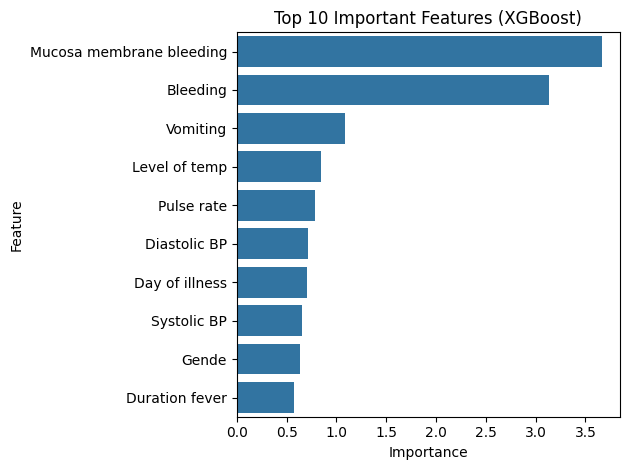

In [38]:
importances = xgb_1.get_booster().get_score(importance_type='gain')

mapped_importances = {x1_features[int(k[1:])]: v for k, v in importances.items()}

mapped_importances_df = pd.DataFrame({
    'Feature': list(mapped_importances.keys()),
    'Importance': list(mapped_importances.values())
}).sort_values(by='Importance', ascending=False)


sns.barplot(x='Importance', y='Feature', data=mapped_importances_df.head(10))
plt.title("Top 10 Important Features (XGBoost)")
plt.tight_layout()
plt.show()

# print(mapped_importances)
# print(importances)

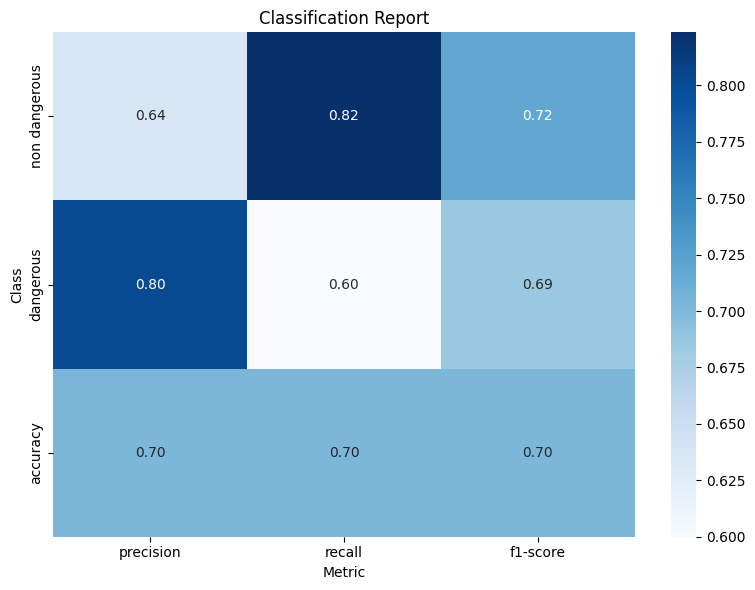

In [23]:
report_dict = classification_report(y1_test, y1_pred, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()
df_report.rename(index={'0': 'non dangerous', '1': 'dangerous'}, inplace=True)
# Optional: drop the summary rows
# df_plot = df_report.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

plt.figure(figsize=(8, 6))
sns.heatmap(df_report.iloc[:3, :3], annot=True, cmap='Blues', fmt=".2f")  # Only show precision, recall, f1-score
plt.title('Classification Report')
plt.ylabel('Class')
plt.xlabel('Metric')
plt.tight_layout()
plt.show()

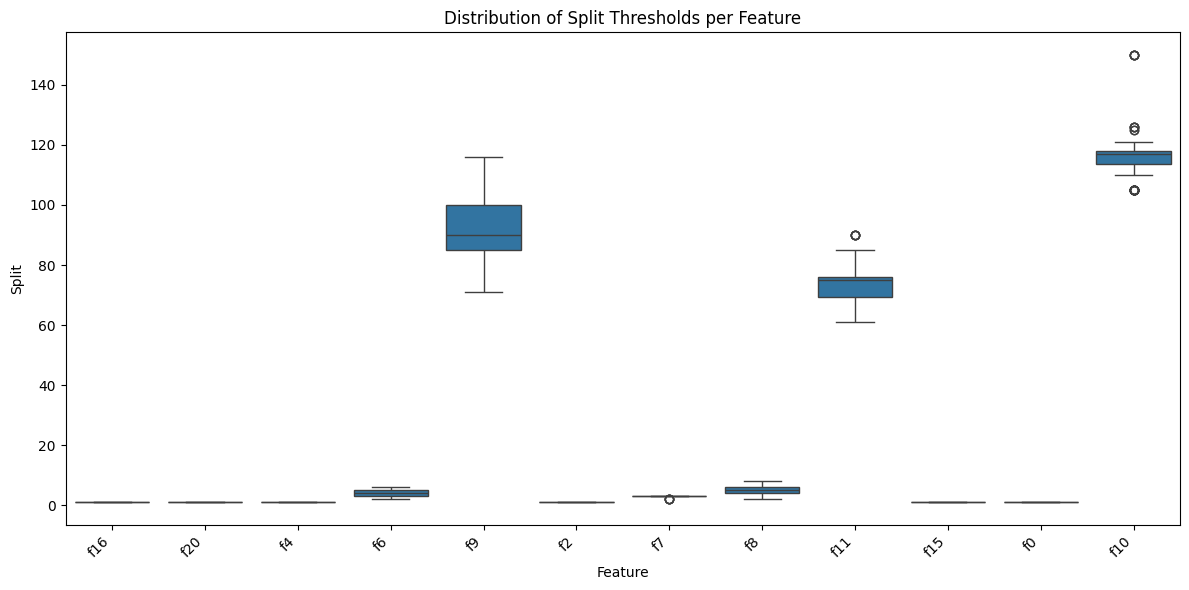

In [28]:
from xgboost import plot_tree
import xgboost as xgb

# Dump trees into a DataFrame
df_split = xgb_1.get_booster().trees_to_dataframe()
# mapped_importances = {x1_features[int(k[1:])]: v for k, v in importances.items()}

# split_values = df_split[~df_split['Feature'].isin(['Leaf'])]  # Remove leaf nodes
# split_per_feature = split_values.groupby('Feature')['Split'].apply(list)

# # Display unique sorted values
# split_per_feature = split_per_feature.apply(lambda x: sorted(set(x)))
# print(split_per_feature)
df_split = df_split[df_split['Feature'] != 'Leaf']

plt.figure(figsize=(12, 6))
sns.boxplot(x='Feature', y='Split', data=df_split)
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Split Thresholds per Feature')
plt.tight_layout()
plt.show()